Object detection is a technique frequently applied in fields such as automated driving.  However, in order to be able to implement object detection, we first need to be able to train a CNN to identify whether an image fed to it is an image of a crater or not.  While many object detection algorithms train on thousands if not millions of images, our network will have to make do with far fewer images.  Several hundred Stardust or analog craters have been studied, providing us with a modest number of images to use to train our crater identification CNN.

We begin by importing the packages necessary to create our CNN.  Keras is a versatile package that allows for the creation of the CNN.

In [1]:
#General import statements

#Linear algebra and dataframes
import numpy as np
import pandas as pd

#Matplotlib and PIL to view plots/images
#%pylab inline
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os as os
from PIL import Image

#For creating our training set from a folder of images
import glob as glob
import cv2 as cv2

#For assessing computation time/efficiency
import timeit

#Keras as the tool for creating the CNN
import keras
from keras import backend as K
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dropout
from keras.layers.core import Activation
#Tools for CONV networks
from keras.layers import Dense, Dropout, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D

#import tensorflow as tf
#sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))

Using TensorFlow backend.


Here we'll view a couple of the images to get an idea for what we're working with.  We'll also determine the range of sizes of the images.

Image is 44 pixels wide.
Image is 41 pixels tall.


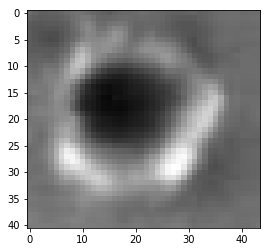

Largest Crater Image Area:   175086 pixels
Largest Crater Image Width:  411 pixels
Largest Crater Image Height: 426 pixels


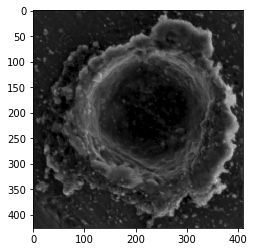

Smallest Crater Image Area:   361 pixels
Smallest Crater Image Width:  19 pixels
Smallest Crater Image Height: 19 pixels
data/CratersCloseUp/Crater100.JPG


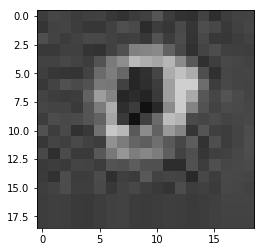

In [2]:
ImageFile1 = 'data/CratersCloseUp/Crater3.jpg'

def get_num_pixels(filepath):
    width, height = Image.open(filepath).size
    return width,height,width*height

Image1width,Image1height,Image1area = get_num_pixels(ImageFile1)

print("Image is " + str(Image1width) + " pixels wide.")
print("Image is " + str(Image1height) + " pixels tall.")

img=mpimg.imread(ImageFile1)
imgplot = plt.imshow(img)
plt.show()


#Determine the max/min sizes of crater images
CraterPath = 'data/CratersCloseUp/'
NoCraterPath = 'data/NoCratersCloseUp/'

MaxCraterImageArea = 0
MaxCraterImageWidth = 0
MaxCraterImageHeight = 0

MinCraterImageArea = 10000
MinCraterImageWidth = 0
MinCraterImageHeight = 0

for file in os.listdir(CraterPath):
    FileName = str(file)
    ImageWidth,ImageHeight,ImageArea = get_num_pixels(str(CraterPath + FileName))
    if ImageArea > MaxCraterImageArea:
        MaxCraterImageArea = ImageArea
        MaxCraterImageWidth = ImageWidth
        MaxCraterImageHeight = ImageHeight
        MaxCraterImageFile = str(CraterPath + FileName)
    if ImageArea < MinCraterImageArea:
        MinCraterImageArea = ImageArea
        MinCraterImageWidth = ImageWidth
        MinCraterImageHeight = ImageHeight
        MinCraterImageFile = str(CraterPath + FileName)
        
print("Largest Crater Image Area:   " + str(MaxCraterImageArea) + " pixels")
print("Largest Crater Image Width:  " + str(MaxCraterImageWidth) + " pixels")
print("Largest Crater Image Height: " + str(MaxCraterImageHeight) + " pixels")
img=mpimg.imread(MaxCraterImageFile)
imgplot = plt.imshow(img)
plt.show()

print("Smallest Crater Image Area:   " + str(MinCraterImageArea) + " pixels")
print("Smallest Crater Image Width:  " + str(MinCraterImageWidth) + " pixels")
print("Smallest Crater Image Height: " + str(MinCraterImageHeight) + " pixels")
img=mpimg.imread(MinCraterImageFile)
print(MinCraterImageFile)
imgplot = plt.imshow(img)
plt.show()

Our images of craters and non-craters come in a wide variety of sizes.  This is due to craters having sizes that can span over an order of magnitude (a few hundred nm to 5+ microns), as well as images being taken at a variety of magnifications.

For this CNN, we'll want all our images resized to the same dimensions before we use them to create our training set.  A CNN's architecture requires all inputs to have the same dimensions.  Craters tend to be circular so we'll use square (N x N) dimensions.  Let's see how a larger crater looks after it's reduced to 20 x 20 pixels.

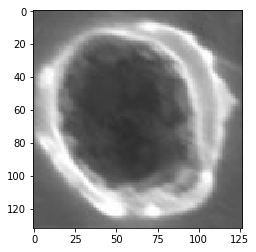

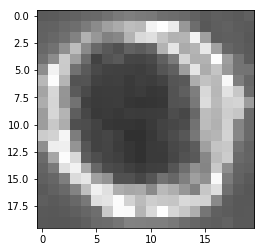

In [4]:
myFile = './data/CratersCloseUp/Crater2.jpg'
image = cv2.imread(myFile)
imgplot = plt.imshow(image)
plt.show()
image = cv2.resize(image, dsize=(20, 20), interpolation=cv2.INTER_CUBIC) #ensure all files are the same shape
imgplot = plt.imshow(image)
plt.show()

Fortunately it seems that craters maintain their core features even after being resized significantly smaller.  The bright crater rim, dark interior, and circular shape are all still easily identifiable.

The loss of data will probably result in some 'close calls' being labeled as craters (some dust/contamination on the foils takes a similar shape/appearance).  However, this is acceptable.  So long as we are able to eliminate most foils from possibly containing craters we'll be saving countless man-hours.  Our results could be improved with better imaging (in other words, better data), but acquiring this data would require far more hours than we're trying to save with this CNN.

Let's create our training sets.  In addition to resizing the craters, we'll also change the images from RGB images to greyscale images (our images are entirely black and white anyways).

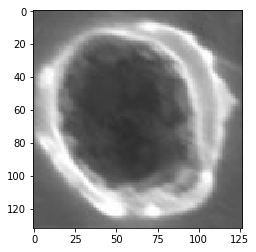

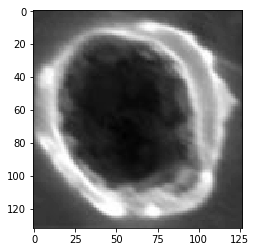

Number of Crater Examples:  301
X_train shape:  (1098, 20, 20, 1)
Y_train shape:  (1098, 1)


In [5]:
X_train = []
Y_train = []

#Decide the pixel by pixel value for our CNN 
inputdim = 20

#Function to change an RGB image array to a grescale image array
def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.299, 0.587, 0.114])

#Example of how rgb2gray affects our images
myFile = './data/CratersCloseUp/Crater2.jpg'
img=mpimg.imread(myFile)
imgplot = plt.imshow(img)
plt.show()

gray = rgb2gray(img)  
plt.imshow(gray, cmap = plt.get_cmap('gray'))
plt.show()

#All files in the 'Crater' folder within the 'data' folder are images containing craters, so y = 1
files = glob.glob('./data/CratersCloseUp/*.jpg')
for myFile in files:
    image = cv2.imread(myFile)
    image = cv2.resize(image, dsize=(inputdim, inputdim), interpolation=cv2.INTER_CUBIC) #ensure all files are the same shape
    image = rgb2gray(image)
    X_train.append(image)
    Y_train.append(1)
    
print('Number of Crater Examples: ', len(X_train))

#All files in the 'Crater' folder within the 'data' folder are images containing craters, so y = 1
files = glob.glob('./data/NoCratersCloseUp/*.jpg')
for myFile in files:
    image = cv2.imread(myFile)
    image = cv2.resize(image, dsize=(inputdim, inputdim), interpolation=cv2.INTER_CUBIC) #ensure all files are the same shape
    image = rgb2gray(image)
    X_train.append(image)
    Y_train.append(0)
    
#Make data proper numpy arrays for later use
X_train = np.array(X_train)
Y_train = np.reshape(Y_train, (len(Y_train),1))
X_train = np.reshape(X_train, (len(X_train),inputdim,inputdim,1))

print('X_train shape: ', X_train.shape)
print('Y_train shape: ', Y_train.shape)

So we have 1098 training examples, 301 of which are images of craters.  Each training image now has the same square dimensions.  And we don't have multiple channels per image, which should help speed up computation.  Changing from rgb images to gray images also appears to have a minimal effect on our image quality, as expected.

When creating X_train and Y_train, we simply took all the 'Crater' examples, appended them, and then took all the 'NoCrater' examples, and then appended them.  As a result, all our positive and negative results are clumped together.  This isn't ideal since our Keras model will use the last fraction of the data as a validation set.  If the last fraction is entirely composed of 'NoCrater' results, our model won't have to work very hard to get perfect accuracy on the validation set (simply returning all 0 values will provide perfect accuracy on the verification data!)

To prevent this we need to shuffle the X_train and Y_train arrays, but do so in unison (so that the corresponding Y values match the X values).  Below we define a quick function to do so and implement it.

In [6]:
def ShuffleInUnison(a, b):
    assert len(a) == len(b)
    p = np.random.permutation(len(a))
    return a[p], b[p]

X_train, Y_train = ShuffleInUnison(X_train, Y_train)

#We should see that the X_train and Y_train data sets have the same shape as before
print('X_train shape: ', X_train.shape)
print('Y_train shape: ', Y_train.shape)

X_train shape:  (1098, 20, 20, 1)
Y_train shape:  (1098, 1)


Here we'll quickly borrow a useful function to keep track of our loss/accuracy as we train our neural network. The code source is linked here: https://gist.github.com/stared/dfb4dfaf6d9a8501cd1cc8b8cb806d2e

In [7]:
from IPython.display import clear_output

class PlotLosses(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        
        self.fig = plt.figure()
        
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):
        
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.i += 1
        
        clear_output(wait=True)
        plt.plot(self.x, self.losses, label="loss")
        plt.plot(self.x, self.val_losses, label="val_loss")
        plt.ylim(0, 1) 
        plt.legend()
        plt.show();
        
plot_losses = PlotLosses()

Our problem is not particularly complex. Craters are fairly normal features (bright, rounded rings with darker interiors), we are only dealing with 1 input channel (grayscale image) we're only looking for a single feature (does the image have a crater or not?), and craters are so rare we'll essentially never have two in an image or any kind of overlap. As a result, we don't need to utilize ideas such as anchor boxes or non-max suppression. We'll use a standard CNN architecture:

Input -> CONV Layer -> MAX POOL -> CONV Layer -> MAX POOL -> FC -> FC -> Output

We'll follow conventional methods of increasing channel size while decreasing image width/height as we progress through the CNN.

In [8]:
model = Sequential()

#40 output filters, so number of channels jumps from 1 to 40
#kernel_size = 5 means we use a 5x5 convolution window
#strides defaults to (1,1) when unspecified, "same" padding means we'll preserve the image size
model.add(Conv2D(40, kernel_size=5, padding="same",input_shape=(inputdim, inputdim, 1), activation = 'relu'))
model.add(Conv2D(50, kernel_size=5, padding="valid", activation = 'relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Dropout(0.4)) #Use dropout for regularization to prevent overfitting


#Second layer
model.add(Conv2D(70, kernel_size=3, padding="same", activation = 'relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Conv2D(100, kernel_size=3, padding="valid", activation = 'relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Dropout(0.4))


#Fully connected (FC) layers
model.add(Flatten())
model.add(Dense(100))
model.add(Activation("relu"))
model.add(Dropout(0.4))

#Output layer
model.add(Dense(1))
model.add(Activation("sigmoid"))
#model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
#model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
keras.optimizers.Adam(lr=0.00001) #Adjust the learning rate
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

#We have to use low batch sizes for memory issues, resulting in noisy loss/accuracy values
#For this reason, we also want to save the best weights after each epoch 
BestWeightsPath = './best_weights2.hdf5'
SaveBestModel = keras.callbacks.ModelCheckpoint(BestWeightsPath, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')
print("Model Completed")

Model Completed


Now we can run the model on our training set. Keras lets us automatically split this into training and test sets (validation_split) to verify the accuracy of our model. In our case, given the low amount of data, we'll likely have a lot of overfitting. But if we can train the model well enough for it to immediately discard a good chunk of our images, we'll be saving a lot of time despite having a damning lack of data.

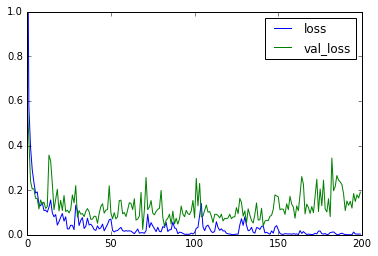


Epoch 00200: val_loss did not improve from 0.02426
Model Fitting Completed


In [8]:
#Convert Y_train to categories (1 = crater, 0 = no crater)
#Convert X_train to a proper array for the model to fit
model.fit(X_train, Y_train, epochs=100, batch_size=32, validation_split=0.2, callbacks=[plot_losses, SaveBestModel]) 
#Note: batch sizes large than 16 exceed computer's 8 GB of RAM and drastically slow down computation

#scores = model.evaluate(X_test, y_test, verbose = 10 )
#print ( scores )
print("Model Fitting Completed")

Great, our simple CNN is returning 99%+ accuracy on determining whether a feature is a crater or not!  Impressive, given how we've drastically reduced many of the images sizes as well as moved from RGB to grayscale input images.

Note that many of the 'Not a crater' examples were chosen specifically because of their likeness to authentic craters!  So we'll likely have a much higher accuracy when looking at random crops of an imput image (which will be 'flat' most of the time).

Now that we have a working CNN to feed input images through, we need to comb images, grab subsets of those images, and use the CNN to determine if the subset contains a crater ('Sliding Window' procedure).  Here we'll implement our 'Sliding Window' algorithm.

In [9]:
#Load the best weights for our CNN thus far
model.load_weights('./best_weights.hdf5')

#Define what window sizes we'd like to try
WINDOW_SIZES = [20]  #For now just trying inputs of 20 x 20 pixels

#We try to find the best bounding box in the image.  We take in an image we're searching for craters, 
#our prediction function (the above CNN), our step size across the image, and the window sizes we're trying
def get_best_bounding_box(img, predict_fn, step=2, window_sizes=WINDOW_SIZES):
    
    #Variable initialization
    best_box = None
    best_box_prob = -np.inf
    
    #Loop over the possible window sizes
    for win_size in window_sizes:
        for top in range(0, img.shape[0] - win_size + 1, step):
            for left in range(0, img.shape[1] - win_size + 1, step):
                
                #Compute the (top, left, bottom, right) of the bounding box
                box = (top, left, top + win_size, left + win_size)
                
                #Crop the original image
                cropped_img = img[box[0]:box[2], box[1]:box[3]]
                cropped_img = rgb2gray(cropped_img)
                cropped_img = np.reshape(cropped_img, (1,win_size,win_size,1))
                
                #Predict how likely the cropped image is a crater.  If best option so far, save it
                #Have to reshape input dimensions to fit our CNN
                box_prob = predict_fn.predict(np.reshape(cropped_img, (1,inputdim,inputdim,1)))
                if box_prob > best_box_prob:
                    
                    #Show what is deemed to be the best crater candidate so far in the image
                    print("New best box prob: " + str(box_prob))
                    print("New best box spot: " + str(box))
                    #Plot what is deemed to be the best crater candidate so far in the image
                    BestImageToPrint = np.reshape(cropped_img, (win_size,win_size))
                    BestImageToPrint = Image.fromarray(BestImageToPrint)
                    plt.imshow(BestImageToPrint)
                    plt.show()
                    
                    #Update variables
                    best_box = box
                    best_box_prob = box_prob
    return best_box, best_box_prob

Now that we've defined our Sliding Window algorithm, let's test it on an image with a crater:

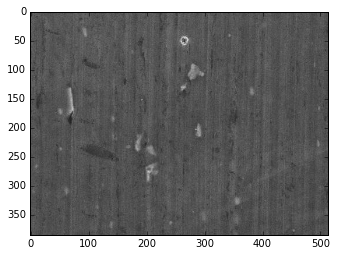

New best box prob: [[  1.46179286e-06]]
New best box spot: (0, 0, 20, 20)


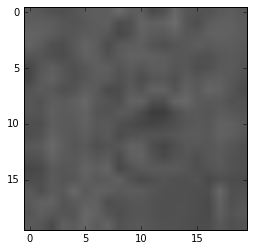

New best box prob: [[  2.70721944e-06]]
New best box spot: (0, 22, 20, 42)


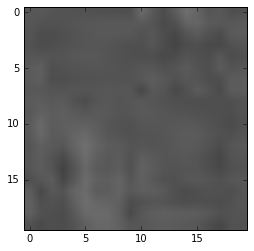

New best box prob: [[  7.15532406e-06]]
New best box spot: (0, 106, 20, 126)


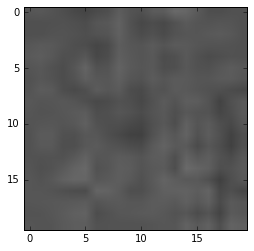

New best box prob: [[ 0.00010805]]
New best box spot: (0, 220, 20, 240)


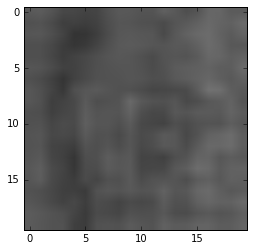

New best box prob: [[ 0.00071153]]
New best box spot: (2, 220, 22, 240)


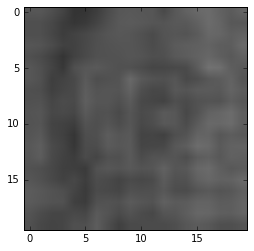

New best box prob: [[ 0.00103049]]
New best box spot: (36, 252, 56, 272)


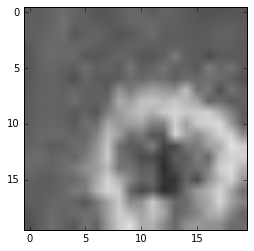

New best box prob: [[ 0.00611944]]
New best box spot: (36, 254, 56, 274)


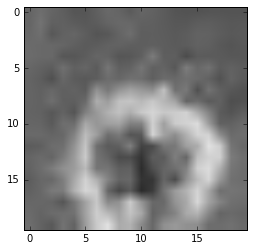

New best box prob: [[ 0.90501946]]
New best box spot: (38, 252, 58, 272)


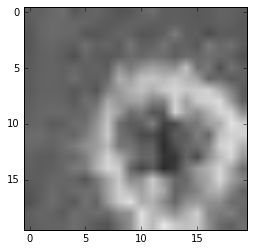

New best box prob: [[ 0.99997449]]
New best box spot: (38, 254, 58, 274)


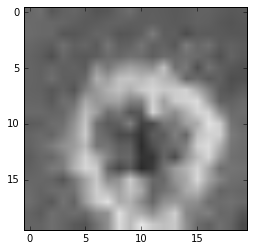

New best box prob: [[ 0.99999869]]
New best box spot: (40, 252, 60, 272)


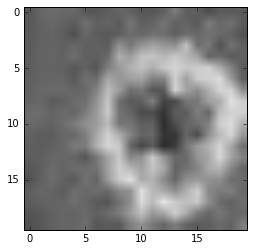

New best box prob: [[ 1.]]
New best box spot: (40, 254, 60, 274)


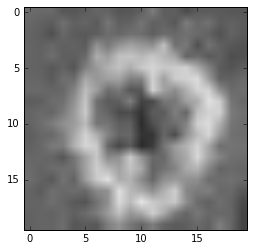

best bounding box (40, 254, 60, 274)
best box probability array([[ 1.]], dtype=float32)


In [9]:
#Let's run an example on an image we were investigating in the simpler model
#Load our test image and plot it; there should be a crater present
TestImageLocation = './data/Crater/Crater1.jpg'
TestImage = cv2.imread(TestImageLocation)
imgplot = plt.imshow(TestImage)
plt.show()

#Run our test image through though the Sliding Window algorithm, checking each window for a crater
best_box, box_prob = get_best_bounding_box(TestImage, predict_fn = model)
print('best bounding box %r' % (best_box, ))
print('best box probability %r' % (box_prob, ))

#Let's look up the image and grab the pixels giving the highest crater prob to verify our function works (for image Crater1)
#TestImageCrater = TestImage[40:60, 254:274]
#imgplot = plt.imshow(TestImageCrater)
#plt.show()

Success!  Our algorithm identified the crater's location, as well as the probability that it was, in fact, a crater (>99%!).  Since our algorithm outputs both the box location and the probability, we can discard any images that never obtain a probability greater than 50% (higher probability of a crater than not).  Doing so will save us a lot of time by not forcing humans to look through images that don't contain craters.

To be safe, let's see what happens when we run the algorithm on an image without a crater.

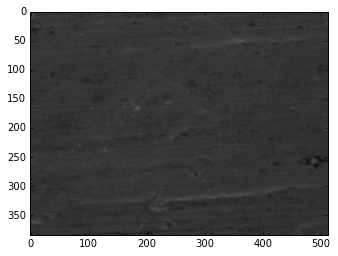

New best box prob: [[  3.88483713e-05]]
New best box spot: (0, 0, 20, 20)


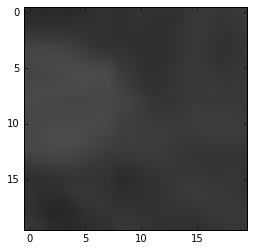

New best box prob: [[  4.98217523e-05]]
New best box spot: (0, 484, 20, 504)


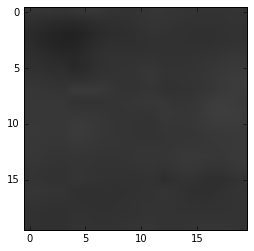

New best box prob: [[  6.80130324e-05]]
New best box spot: (12, 260, 32, 280)


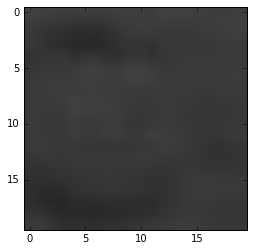

New best box prob: [[  7.53122440e-05]]
New best box spot: (14, 370, 34, 390)


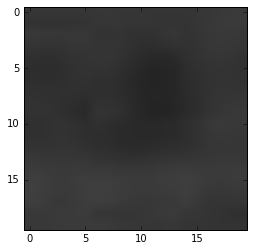

New best box prob: [[ 0.00013279]]
New best box spot: (58, 394, 78, 414)


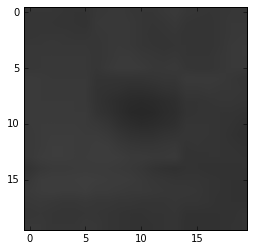

New best box prob: [[ 0.00016021]]
New best box spot: (100, 26, 120, 46)


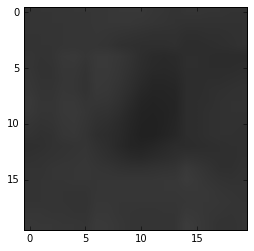

New best box prob: [[ 0.00022174]]
New best box spot: (102, 26, 122, 46)


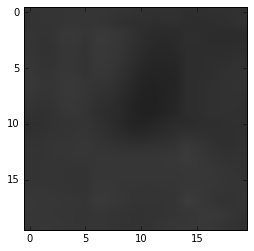

New best box prob: [[ 0.00035968]]
New best box spot: (244, 468, 264, 488)


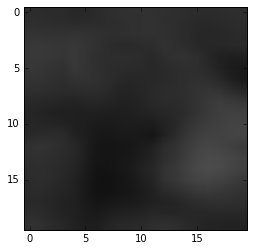

New best box prob: [[ 0.00039047]]
New best box spot: (270, 272, 290, 292)


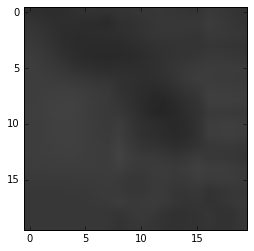

New best box prob: [[ 0.00092351]]
New best box spot: (270, 274, 290, 294)


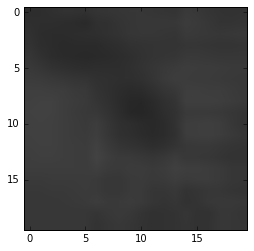

best bounding box (270, 274, 290, 294)
best box probability array([[ 0.00092351]], dtype=float32)


In [69]:
#Let's run an example on an image we were investigating in the simpler model
#Load our test image and plot it; there should be a crater present
TestImageLocation = './data/NoCrater/NoCrater10.jpg'
TestImage = cv2.imread(TestImageLocation)
imgplot = plt.imshow(TestImage)
plt.show()

#Run our test image through though the Sliding Window algorithm, checking each window for a crater
best_box, box_prob = get_best_bounding_box(TestImage, predict_fn = model)
print('best bounding box %r' % (best_box, ))
print('best box probability %r' % (box_prob, ))

In this case, the best crater probability is low.  This is expected as there's no crater in this image.  This image would have been thrown away and would not have required further investigation by human eyes, saving us time.

Since these craters are rare, it's generally better to have false positives than false negatives.  The rates of these events can be controlled by adjusting the probabilities that we'll deem high enough to warrant further investigation.  Conservative probabilities may only take images with probabilities > 0.8 (to minimize any false negative possibilities), whereas more accurate (but possibly excluding true craters) probability restrictions will be > 0.98.

Let's see what the highest probabilities of craters being found are for our NoCraters examples.  We can use these values to shape our decision on what probability restrictions we should use.

Total calcuation time: -12480.076693489083. Avg time per file: 64.66360981082427


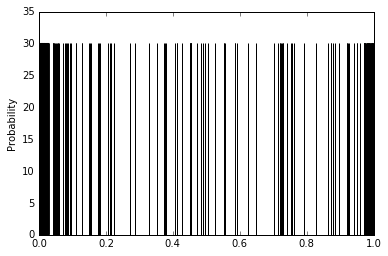

In [ ]:
start = timeit.default_timer()

files = glob.glob('./data/NoCrater/*.jpg')
NoCratersBoxProbList = []
placeholder = 1
for myFile in files:
    print('Working on file ' + str(myFile) + ', #' + str(placeholder) + ' out of ' + str(len(files)) + ' total files', end='\r')
    image = cv2.imread(myFile)
    best_box, box_prob = get_best_bounding_box(image, predict_fn = model)
    NoCratersBoxProbList.append(box_prob)
    placeholder = placeholder + 1
    
stop = timeit.default_timer()
print('Total calcuation time: ' + str(stop-start) + '. Avg time per file: ' + str((stop-start)/(len(files))))
    
#%matplotlib inline
plt.hist(NoCratersBoxProbList, normed=True, bins=30)
plt.ylabel('Probability');

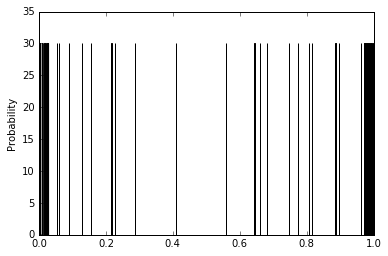

In [10]:
files = glob.glob('./data/Crater/*.jpg')
CratersBoxProbList = []
placeholder = 1
for myFile in files:
    print('Working on file ' + str(myFile) + ', #' + str(placeholder) + ' out of ' + str(len(files)) + ' total files', end='\r')
    image = cv2.imread(myFile)
    best_box, box_prob = get_best_bounding_box(image, predict_fn = model)
    CratersBoxProbList.append(box_prob)
    placeholder = placeholder + 1
    
#%matplotlib inline
plt.hist(CratersBoxProbList, normed=True, bins=30)
plt.ylabel('Probability');

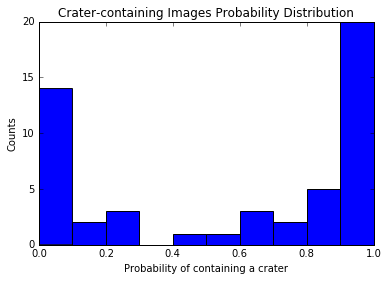

In [90]:
x = np.concatenate(CratersBoxProbList, axis=0 )
x = np.array(x)

#bins = np.arange(0, 1,.2) # fixed bin size
bins = [0,.1,.2,.3,.4,.5,.6,.7,.8,.9,1]

plt.xlim(0,1)
plt.ylim(0,20)

plt.hist(x, bins=bins, histtype = 'bar')
plt.title('Crater-containing Images Probability Distribution')
plt.xlabel('Probability of containing a crater')
plt.ylabel('Counts')

plt.show()

While a number of images not containing craters are still returning high probabilities, many of them are being rated very low.  This is OK.  A large number of images are still being successfully screened out.

However, we see that our CNN is still missing a good chunk of craters.  Almost 15 images containing craters were given near 0% chance of having any!  What kinds of images are returning these erroneous results?  Let's look more closely.

(20, 20)


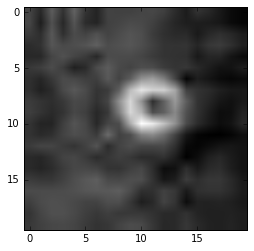

[[  3.44620249e-10]]
(20, 20)


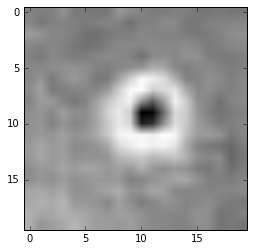

[[  6.20353512e-06]]
(20, 20)


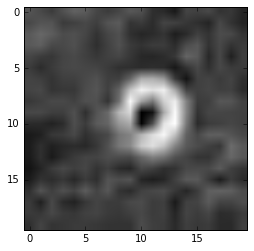

[[  1.13799121e-08]]


In [85]:
TestImageLocation = './data/Crater/Crater11.jpg'
TestImageCrater = cv2.imread(TestImageLocation)
TestImageCrater = TestImageCrater[235:255, 97:117]
TestImageCrater = rgb2gray(TestImageCrater)
print(np.shape(TestImageCrater))
imgplot = plt.imshow(TestImageCrater, cmap = plt.get_cmap('gray'))
plt.show()

box_prob = model.predict(np.reshape(TestImageCrater, (1,20,20,1)))
print(box_prob)

TestImageLocation = './data/Crater/Crater17.jpg'
TestImageCrater = cv2.imread(TestImageLocation)
TestImageCrater = TestImageCrater[255:275, 350:370]
TestImageCrater = rgb2gray(TestImageCrater)
print(np.shape(TestImageCrater))
imgplot = plt.imshow(TestImageCrater, cmap = plt.get_cmap('gray'))
plt.show()

box_prob = model.predict(np.reshape(TestImageCrater, (1,20,20,1)))
print(box_prob)

TestImageLocation = './data/Crater/Crater20.jpg'
TestImageCrater = cv2.imread(TestImageLocation)
TestImageCrater = TestImageCrater[335:355, 70:90]
TestImageCrater = rgb2gray(TestImageCrater)
print(np.shape(TestImageCrater))
imgplot = plt.imshow(TestImageCrater, cmap = plt.get_cmap('gray'))
plt.show()

box_prob = model.predict(np.reshape(TestImageCrater, (1,20,20,1)))
print(box_prob)

All of our 'poor' results are craters that are extremely small.  Many of them are less than 10 x 10 pixels!  Since our training images were all sized to take up the entire frame (with rims nearly reaching the edges of the 'window' we were imaging) the CNN is likely interpreting these results as 'dust' or another feature too small to be a crater.  We can try expanding the small regions containing these craters (10x10 pixels) into 20x20 images and seeing if the CNN performs better.

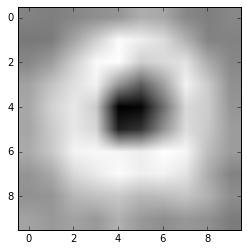

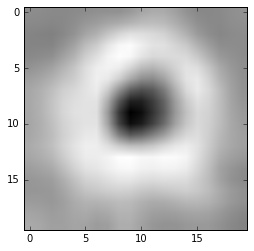

[[ 1.]]


In [89]:
#Establish and show the new 10x10 input we're dealing with
TestImageLocation = './data/Crater/Crater17.jpg'
TestImageCrater = cv2.imread(TestImageLocation)
TestImageCrater = TestImageCrater[260:270, 356:366] #10x10 pixel input instead of 20x20
TestImageCrater = rgb2gray(TestImageCrater)
imgplot = plt.imshow(TestImageCrater, cmap = plt.get_cmap('gray'))
plt.show()


TestImageCrater = cv2.resize(TestImageCrater, dsize=(20, 20), interpolation=cv2.INTER_CUBIC) #ensure all files are the same shape
imgplot = plt.imshow(TestImageCrater, cmap = plt.get_cmap('gray'))
plt.show()

box_prob = model.predict(np.reshape(TestImageCrater, (1,20,20,1)))
print(box_prob)

After focusing on a smaller region, expanding that region to a 20x20 pixel image, and re-running through the CNN, we see much better results!  Now we're giving 100% confidence that this is a crater (much better than the << 1% confidence from before).

It seems if we want to be able to detect all of our craters, we'll have to use a smaller sliding window (10x10 pixels) in addition to our earlier 20x20 sliding pixel window.  We'll have to resize these 10x10 pixel images into 20x20 pixel images to have them work with our current CNN.  Hopefully doing so will greatly improve our accuracy in detecting craters!

Note, however, that our crater probabilities will only stay even or go up even for the images without craters.  Again, we're willing to accept this as we'd rather have false positives than false negatives.

Also note that we're not accounting for even smaller craters!  In the case of craters on the scale of 100nm we simply don't have the resolution to observe these features anyways in our electron microscope images (the 'craters' would only be a couple of pixels across!).  Thus, we won't consider them as options for the time being.

Let's improve our sliding window algorithm to also take in window sizes of 10x10 and 20x20 pixels.

In [10]:
#Load the best weights for our CNN thus far
model.load_weights('./best_weights.hdf5')

#Define what window sizes we'd like to try
WINDOW_SIZES = [20,10]  #For now just trying inputs of 20 x 20 pixels

#We try to find the best bounding box in the image.  We take in an image we're searching for craters, 
#our prediction function (the above CNN), our step size across the image, and the window sizes we're trying
def get_best_bounding_box2(img, predict_fn, step=2, window_sizes=WINDOW_SIZES):
    
    #Variable initialization
    best_box = None
    best_box_prob = -np.inf
    
    #print('Starting sliding window algorithm')
    
    #Loop over the possible window sizes
    for win_size in window_sizes:
        
        #print('Looping over windows of size ' + str(win_size))
        
        for top in range(0, img.shape[0] - win_size + 1, step):
            for left in range(0, img.shape[1] - win_size + 1, step):
                
                #Compute the (top, left, bottom, right) of the bounding box
                box = (top, left, top + win_size, left + win_size)
                
                #Crop the original image
                cropped_img = img[box[0]:box[2], box[1]:box[3]]
                cropped_img = rgb2gray(cropped_img)
                if win_size != inputdim: #Make sure our image matches dimensions needed for CNN
                    cropped_img = cv2.resize(cropped_img, dsize=(inputdim,inputdim), interpolation = cv2.INTER_CUBIC)
                cropped_img = np.reshape(cropped_img, (1,inputdim,inputdim,1))
                
                #Predict how likely the cropped image is a crater.  If best option so far, save it
                #Have to reshape input dimensions to fit our CNN
                box_prob = predict_fn.predict(np.reshape(cropped_img, (1,inputdim,inputdim,1)))
                if box_prob > best_box_prob:
                    
                    #Show what is deemed to be the best crater candidate so far in the image
                    #print("New best box prob: " + str(box_prob))
                    #print("New best box spot: " + str(box))
                    #Plot what is deemed to be the best crater candidate so far in the image
                    #BestImageToPrint = np.reshape(cropped_img, (win_size,win_size))
                    #BestImageToPrint = np.reshape(cropped_img, (inputdim,inputdim))
                    #BestImageToPrint = Image.fromarray(BestImageToPrint)
                    #plt.imshow(BestImageToPrint)
                    #plt.show()
                    
                    #Update variables
                    best_box = box
                    best_box_prob = box_prob
                    
                    #Stop looking for craters if we're positive we've got one
                    if best_box_prob > 0.999:
                        return best_box, best_box_prob
    return best_box, best_box_prob

Let's try again on one of these small craters using the new sliding window algorithm, which will use sliding windows of 10x10 and 20x20.

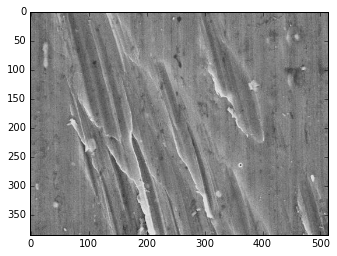

Starting sliding window algorithm
Looping over windows of size 10
New best box prob: [[  3.50814711e-09]]
New best box spot: (0, 0, 10, 10)


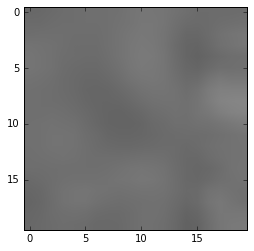

New best box prob: [[  1.83951610e-08]]
New best box spot: (0, 2, 10, 12)


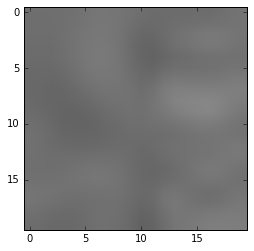

New best box prob: [[  2.08203286e-08]]
New best box spot: (0, 6, 10, 16)


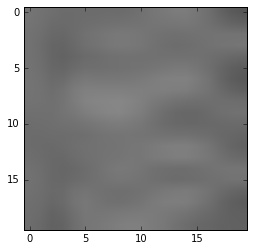

New best box prob: [[  4.91635426e-08]]
New best box spot: (0, 10, 10, 20)


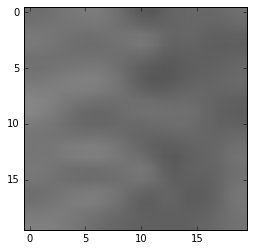

New best box prob: [[  9.17473173e-08]]
New best box spot: (0, 14, 10, 24)


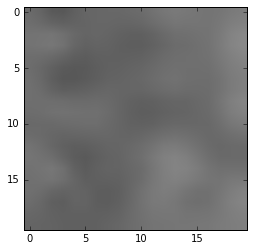

New best box prob: [[  1.02875077e-07]]
New best box spot: (0, 18, 10, 28)


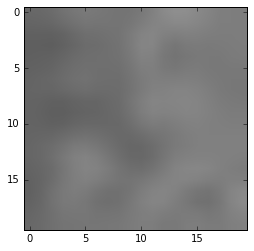

New best box prob: [[  5.96928089e-07]]
New best box spot: (0, 34, 10, 44)


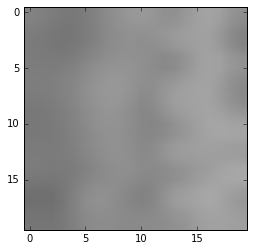

New best box prob: [[  5.97999770e-06]]
New best box spot: (0, 60, 10, 70)


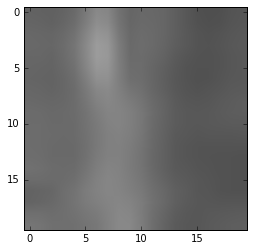

New best box prob: [[  6.21052595e-06]]
New best box spot: (0, 114, 10, 124)


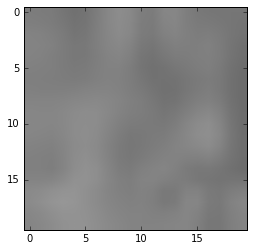

New best box prob: [[ 0.00015661]]
New best box spot: (0, 434, 10, 444)


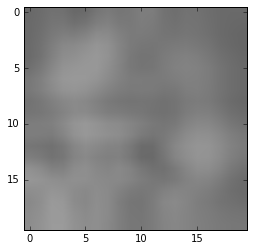

New best box prob: [[ 0.00073627]]
New best box spot: (6, 56, 16, 66)


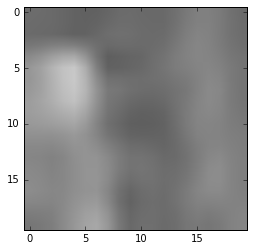

New best box prob: [[ 0.00238106]]
New best box spot: (16, 406, 26, 416)


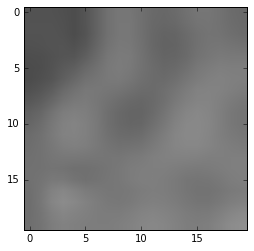

New best box prob: [[ 0.00840872]]
New best box spot: (234, 88, 244, 98)


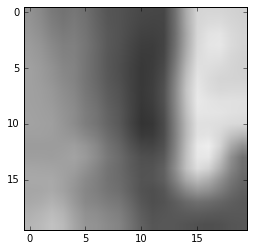

New best box prob: [[ 1.]]
New best box spot: (260, 356, 270, 366)


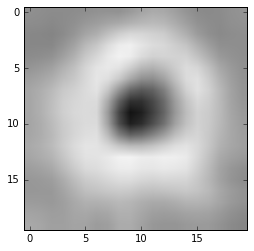

Looping over windows of size 20
best bounding box (260, 356, 270, 366)
best box probability array([[ 1.]], dtype=float32)


In [24]:
TestImageLocation = './data/Crater/Crater17.jpg'
TestImage = cv2.imread(TestImageLocation)
imgplot = plt.imshow(TestImage)
plt.show()

#Run our test image through though the Sliding Window algorithm, checking each window for a crater
best_box, box_prob = get_best_bounding_box2(TestImage, predict_fn = model)
print('best bounding box %r' % (best_box, ))
print('best box probability %r' % (box_prob, ))

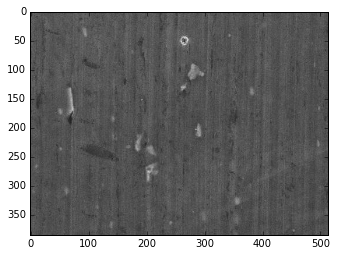

Starting sliding window algorithm
Looping over windows of size 10
New best box prob: [[  1.22579795e-08]]
New best box spot: (0, 0, 10, 10)


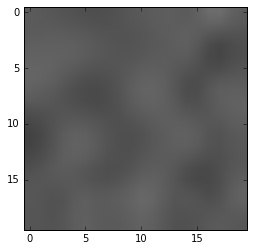

New best box prob: [[  7.83513556e-08]]
New best box spot: (0, 2, 10, 12)


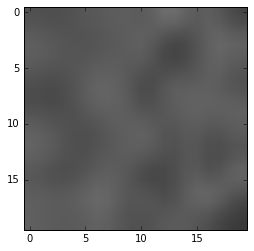

New best box prob: [[  2.13243624e-07]]
New best box spot: (0, 4, 10, 14)


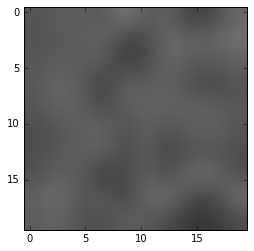

New best box prob: [[  5.68289522e-07]]
New best box spot: (0, 8, 10, 18)


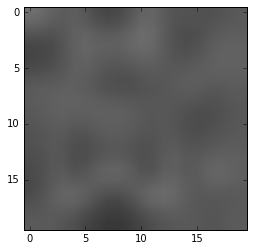

New best box prob: [[  2.33266073e-05]]
New best box spot: (0, 10, 10, 20)


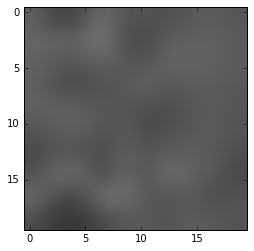

New best box prob: [[  2.62790072e-05]]
New best box spot: (0, 108, 10, 118)


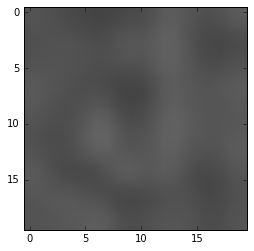

New best box prob: [[  4.70008599e-05]]
New best box spot: (0, 302, 10, 312)


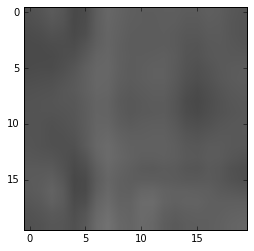

New best box prob: [[  6.32369192e-05]]
New best box spot: (4, 222, 14, 232)


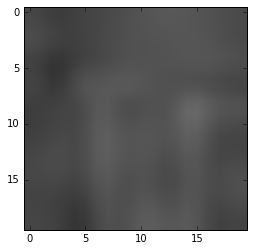

New best box prob: [[  6.90078305e-05]]
New best box spot: (6, 222, 16, 232)


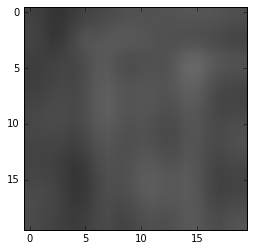

New best box prob: [[  8.73805911e-05]]
New best box spot: (8, 104, 18, 114)


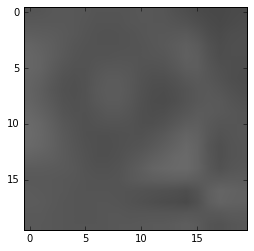

New best box prob: [[ 0.00063737]]
New best box spot: (8, 450, 18, 460)


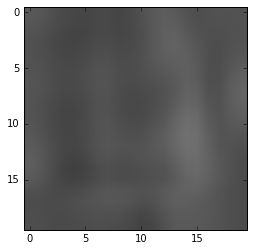

New best box prob: [[ 0.00117215]]
New best box spot: (40, 252, 50, 262)


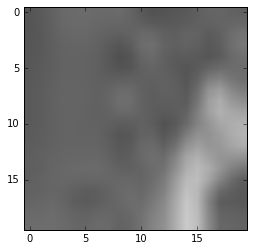

New best box prob: [[ 0.07899845]]
New best box spot: (40, 264, 50, 274)


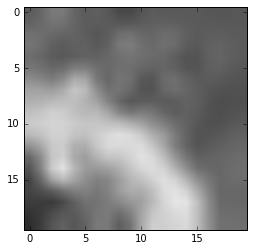

New best box prob: [[ 0.99223268]]
New best box spot: (50, 260, 60, 270)


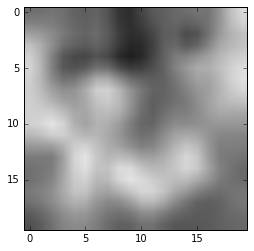

Looping over windows of size 20
New best box prob: [[ 0.99997449]]
New best box spot: (38, 254, 58, 274)


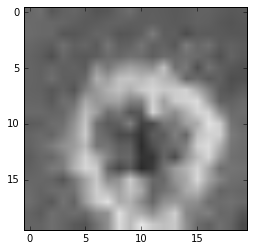

New best box prob: [[ 0.99999869]]
New best box spot: (40, 252, 60, 272)


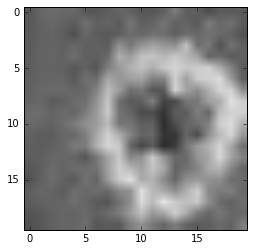

New best box prob: [[ 1.]]
New best box spot: (40, 254, 60, 274)


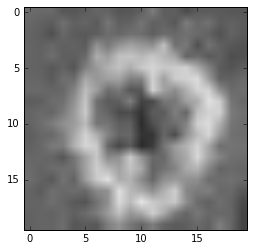

best bounding box (40, 254, 60, 274)
best box probability array([[ 1.]], dtype=float32)


In [25]:
TestImageLocation = './data/Crater/Crater1.jpg'
TestImage = cv2.imread(TestImageLocation)
imgplot = plt.imshow(TestImage)
plt.show()

#Run our test image through though the Sliding Window algorithm, checking each window for a crater
best_box, box_prob = get_best_bounding_box2(TestImage, predict_fn = model)
print('best bounding box %r' % (best_box, ))
print('best box probability %r' % (box_prob, ))

The new algorithm that looks at window sizes of both 10 and 20 appears to be working correctly so far.  Let's try using this improved sliding window algorithm to reassess our images containing craters.

Note, however, that by using 2 sliding windows we'll now take roughly twice as long to analyze an image.

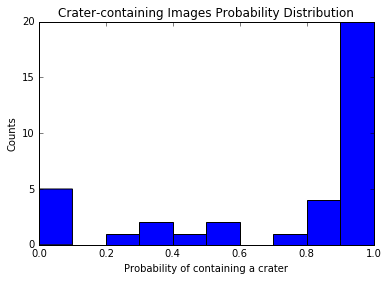

In [29]:
files = glob.glob('./data/Crater/*.jpg')
CratersBoxProbList2 = []
placeholder = 1
for myFile in files:
    print('Working on file ' + str(myFile) + ', #' + str(placeholder) + ' out of ' + str(len(files)) + ' total files', end='\r')
    image = cv2.imread(myFile)
    best_box, box_prob = get_best_bounding_box2(image, predict_fn = model)
    CratersBoxProbList2.append(box_prob)
    placeholder = placeholder + 1

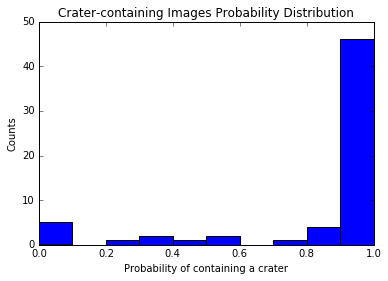

In [37]:
x = np.concatenate(CratersBoxProbList2, axis=0)
x = np.array(x)

#bins = np.arange(0, 1,.2) # fixed bin size
bins = [0,.1,.2,.3,.4,.5,.6,.7,.8,.9,1]

plt.xlim(0,1)
plt.ylim(0,50)

plt.hist(x, bins=bins, histtype = 'bar')
plt.title('Crater-containing Images Probability Distribution')
plt.xlabel('Probability of containing a crater')
plt.ylabel('Counts')

plt.show()

We've dramatically improved the number of false negatives we get, but we still have 10-15 craters that aren't being well recognized by the CNN.  What might be the cause?  Let's look at which craters are going undetected.

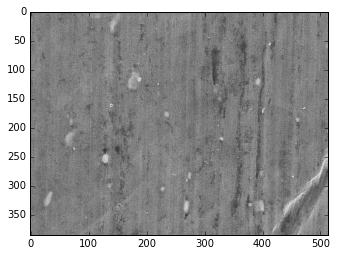

(10, 10)


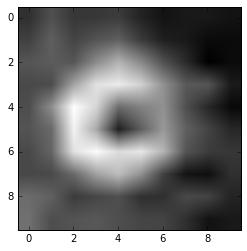

Crater prob of box centered on our crater = [[ 0.99887902]]
Crater prob with step size 2 = [[ 0.23162544]]
Crater prob with step size 1 = [[ 0.99887902]]


In [75]:
TestImageLocation = './data/Crater/Crater37.jpg'
TestImageCrater = cv2.imread(TestImageLocation)
origimage = TestImageCrater

imgplot = plt.imshow(TestImageCrater, cmap = plt.get_cmap('gray'))
plt.show()

TestImageCrater = TestImageCrater[157:167, 135:145]
TestImageCrater = rgb2gray(TestImageCrater)
print(np.shape(TestImageCrater))
imgplot = plt.imshow(TestImageCrater, cmap = plt.get_cmap('gray'))
plt.show()

TestImageCrater = cv2.resize(TestImageCrater, dsize=(inputdim,inputdim), interpolation = cv2.INTER_CUBIC)
TestImageCrater = np.reshape(TestImageCrater, (1,inputdim,inputdim,1))

box_prob = model.predict(np.reshape(TestImageCrater, (1,20,20,1)))
print("Crater prob of box centered on our crater = " + str(box_prob))
best_box, box_prob = get_best_bounding_box2(origimage, predict_fn = model, step=2)
print("Crater prob with step size 2 = " + str(box_prob))
best_box, box_prob = get_best_bounding_box2(origimage, predict_fn = model, step=1)
print("Crater prob with step size 1 = " + str(box_prob))

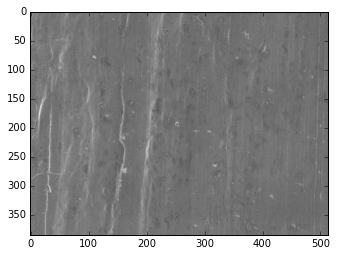

(10, 10)


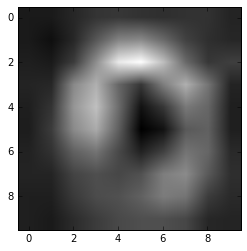

Crater prob of box centered on our crater = [[ 0.7725578]]
Crater prob with step size 2 = [[ 0.35060644]]
Crater prob with step size 1 = [[ 0.7725578]]


In [76]:
TestImageLocation = './data/Crater/Crater44.jpg'
TestImageCrater = cv2.imread(TestImageLocation)
origimage = TestImageCrater

imgplot = plt.imshow(TestImageCrater, cmap = plt.get_cmap('gray'))
plt.show()

TestImageCrater = TestImageCrater[189:199, 247:257]
TestImageCrater = rgb2gray(TestImageCrater)
print(np.shape(TestImageCrater))
imgplot = plt.imshow(TestImageCrater, cmap = plt.get_cmap('gray'))
plt.show()

TestImageCrater = cv2.resize(TestImageCrater, dsize=(inputdim,inputdim), interpolation = cv2.INTER_CUBIC)
TestImageCrater = np.reshape(TestImageCrater, (1,inputdim,inputdim,1))

box_prob = model.predict(np.reshape(TestImageCrater, (1,20,20,1)))
print("Crater prob of box centered on our crater = " + str(box_prob))
best_box, box_prob = get_best_bounding_box2(origimage, predict_fn = model, step=2)
print("Crater prob with step size 2 = " + str(box_prob))
best_box, box_prob = get_best_bounding_box2(origimage, predict_fn = model, step=1)
print("Crater prob with step size 1 = " + str(box_prob))

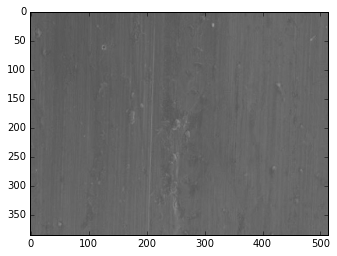

(10, 10)


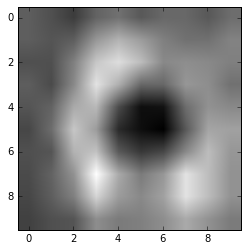

Crater prob of box centered on our crater = [[ 0.80517679]]
Crater prob with step size 2 = [[ 0.00246394]]
Crater prob with step size 1 = [[ 0.80517679]]


In [83]:
TestImageLocation = './data/Crater/Crater45.jpg'
TestImageCrater = cv2.imread(TestImageLocation)
origimage = TestImageCrater

imgplot = plt.imshow(TestImageCrater, cmap = plt.get_cmap('gray'))
plt.show()

TestImageCrater = TestImageCrater[57:67, 121:131]
TestImageCrater = rgb2gray(TestImageCrater)
print(np.shape(TestImageCrater))
imgplot = plt.imshow(TestImageCrater, cmap = plt.get_cmap('gray'))
plt.show()


TestImageCrater = cv2.resize(TestImageCrater, dsize=(inputdim,inputdim), interpolation = cv2.INTER_CUBIC)
TestImageCrater = np.reshape(TestImageCrater, (1,inputdim,inputdim,1))

box_prob = model.predict(np.reshape(TestImageCrater, (1,20,20,1)))
print("Crater prob of box centered on our crater = " + str(box_prob))
best_box, box_prob = get_best_bounding_box2(origimage, predict_fn = model, step=2)
print("Crater prob with step size 2 = " + str(box_prob))
best_box, box_prob = get_best_bounding_box2(origimage, predict_fn = model, step=1)
print("Crater prob with step size 1 = " + str(box_prob))

So we see that by using step sizes of 1 instead of 2, we can land on our crater more accurately a high percentage of the time.  Our CNN seems to be highly sensitive to changes of just a pixel in different directions, likely b/c these craters themselves are only ~7 pixels by 7 pixels in some cases!

However, by changing from a step size of 2 to a step size of 1, it takes ~4 times longer to sweep over the entire image.  Additionally, since we're now looking at windows of size 10 and size 20, we've added another factor of ~2 to the time to analyze one image.  So now each image will take ~8 minutes instead of the original 1 minute!  However, if this results in a lack of false negatives, it may be worth it.  Additionally, running this algorithm on a more powerful computer or cluster than my work desktop would likely greatly speed up this time as well.

Another angle to consider is that, even with windows of size 10 and step sizes of 1, we're still getting crater probabilities of ~80%, rather than 100%, in the more difficult cases (very small craters).  This suggests that we should aim to reduce the bias in our CNN.  This could be done by deepening the CNN, giving it more layers and allowing more complex analysis.  We could also try using the original 3 input channels, which may allow us to retain ever so slightly more information about the craters, which already only constitute ~50 pixels.  However, each window we image in the sliding window algorithm has to feed forward through our CNN, so this also would likely slow down the rate at which we can analyze these images.

I've already added a check to immediately end the sliding window algorithm if the probability of a crater being present is >0.999 (in which case we've almost certainly found a crater).  Hopefully this will speed up the process a bit by stopping analysis once a crater is found.

Let's see how our algorithm performs on the images with the step sizes of 1 and windows of 10 and 20.

In [84]:
start = timeit.default_timer()

files = glob.glob('./data/Crater/*.jpg')
CratersBoxProbList3 = []
placeholder = 1
for myFile in files:
    print('Working on file ' + str(myFile) + ', #' + str(placeholder) + ' out of ' + str(len(files)) + ' total files', end='\r')
    image = cv2.imread(myFile)
    best_box, box_prob = get_best_bounding_box2(image, predict_fn = model, step = 1)
    CratersBoxProbList3.append(box_prob)
    placeholder = placeholder + 1
    
stop = timeit.default_timer()
print('Total calcuation time: ' + str(stop-start) + '. Avg time per file: ' + str((stop-start)/(len(files))))

Total calcuation time: 18135.19837382347. Avg time per file: 292.5031995777979


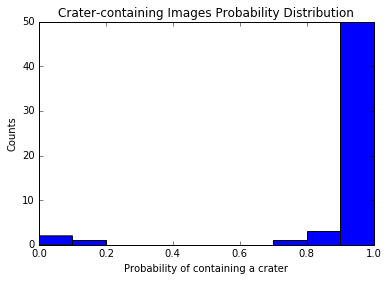

In [85]:
x = np.concatenate(CratersBoxProbList3, axis=0)
x = np.array(x)

#bins = np.arange(0, 1,.2) # fixed bin size
bins = [0,.1,.2,.3,.4,.5,.6,.7,.8,.9,1]

plt.xlim(0,1)
plt.ylim(0,50)

plt.hist(x, bins=bins, histtype = 'bar')
plt.title('Crater-containing Images Probability Distribution')
plt.xlabel('Probability of containing a crater')
plt.ylabel('Counts')

plt.show()

In [86]:
start = timeit.default_timer()

files = glob.glob('./data/NoCrater/*.jpg')
NoCratersBoxProbList3 = []
placeholder = 1
for myFile in files:
    print('Working on file ' + str(myFile) + ', #' + str(placeholder) + ' out of ' + str(len(files)) + ' total files', end='\r')
    image = cv2.imread(myFile)
    best_box, box_prob = get_best_bounding_box2(image, predict_fn = model, step = 1)
    NoCratersBoxProbList3.append(box_prob)
    placeholder = placeholder + 1
    
stop = timeit.default_timer()
print('Total calcuation time: ' + str(stop-start) + '. Avg time per file: ' + str((stop-start)/(len(files))))

Total calcuation time: 91163.42954989747. Avg time per file: 472.3493759062045


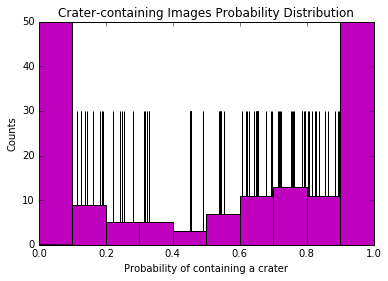

In [87]:
plt.hist(NoCratersBoxProbList3, normed=True, bins=30)
plt.ylabel('Probability');

x = np.concatenate(NoCratersBoxProbList3, axis=0)
x = np.array(x)

#bins = np.arange(0, 1,.2) # fixed bin size
bins = [0,.1,.2,.3,.4,.5,.6,.7,.8,.9,1]

plt.xlim(0,1)
plt.ylim(0,100)

plt.hist(x, bins=bins, histtype = 'bar')
plt.title('Crater-containing Images Probability Distribution')
plt.xlabel('Probability of containing a crater')
plt.ylabel('Counts')

plt.show()